In [19]:
import json
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import optuna
import xgboost as xgb

# Load the JSON data
with open('descriptors_WA.json', 'r') as file:
    data = json.load(file)

In [20]:
elements_to_exclude = ['Fe', 'Co', 'Mn', 'Ni']

# Filter the dictionary
descriptors_json = {
    formula: value
    for formula, value in data.items()
    if not any(element in formula for element in elements_to_exclude)
}


In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Example data processing
formulas = []
descriptors = []
e_f_values = []

for formula, values in data.items():
    if -3 < values[1] < 3:  # Only include values within the range -10 < e_f < 10
        descriptors.append(values[0])  # Descriptor values
        e_f_values.append(values[1])   # e_f value
        formulas.append(formula)

# Create DataFrame
df = pd.DataFrame(descriptors)
df['e_f'] = e_f_values
df['formula'] = formulas

# Separate data that can be used for testing (within -2.5 < e_f < 2.5)
test_candidates = df[(df['e_f'] >= -2.5) & (df['e_f'] <= 2.5)]

# Split the test candidates into a test set (10% of the total data)
test_df = test_candidates.sample(frac=0.1, random_state=42)  # 10% sample of data in the desired e_f range

# The remaining data (after excluding the test set) will be used for training
train_df = df[~df.index.isin(test_df.index)]

# Split into features (X) and target (y) for training and testing sets
X_train = train_df.drop(columns=['e_f', 'formula'])  # Training features
y_train = train_df['e_f']                            # Training target

X_test = test_df.drop(columns=['e_f', 'formula'])    # Test features
y_test = test_df['e_f']                              # Test target

# Now X_train, y_train, X_test, and y_test are ready to use without overlapping data
print("Training Set Size:", X_train.shape[0])
print("Test Set Size:", X_test.shape[0])


Training Set Size: 7161
Test Set Size: 741


In [22]:
# Initialize and train the Random Forest Regressor
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def objective(trial):
    # Suggest values for the hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 500) # (50, 500) 
    max_depth = trial.suggest_int('max_depth', 40, 80) # (2,10) 
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)


    # Initialize and train the Random Forest Regressor with the suggested hyperparameters
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1
    )
    
    model.fit(X_train_scaled, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test_scaled)

    r2 = r2_score(y_test, y_pred)
    
    # We want to maximize R-squared, so we return it directly
    return r2

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

[I 2024-11-07 08:21:22,285] A new study created in memory with name: no-name-928bf752-606e-4706-a8d3-d312f5465824
[I 2024-11-07 08:21:22,782] Trial 0 finished with value: 0.32450190223842645 and parameters: {'n_estimators': 77, 'max_depth': 77, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.32450190223842645.
[I 2024-11-07 08:21:25,172] Trial 1 finished with value: 0.3381343923572878 and parameters: {'n_estimators': 385, 'max_depth': 68, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.3381343923572878.
[I 2024-11-07 08:21:27,373] Trial 2 finished with value: 0.30474402556821834 and parameters: {'n_estimators': 397, 'max_depth': 61, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.3381343923572878.
[I 2024-11-07 08:21:29,875] Trial 3 finished with value: 0.3438116255781368 and parameters: {'n_estimators': 353, 'max_depth': 73, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.3438116255781368.
[I 2024-11-07 08:21:31,422] Trial 4 finished with value: 0.2926422151922

Best hyperparameters: {'n_estimators': 456, 'max_depth': 80, 'min_samples_leaf': 1}


In [23]:
# Train the RandomForestRegressor with the best hyperparameters
best_model = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
best_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = best_model.predict(X_test_scaled)
y_pred_train = best_model.predict(X_train_scaled)

# Evaluate the optimized model
mse = mean_squared_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)
r2_train = r2_score(y_train, y_pred_train)

print("Optimized Mean Squared Error:", mse)
print("Optimized R-squared for the train:", r2_train)
print("Optimized R-squared for the test:", r2_test)

Optimized Mean Squared Error: 0.760251168419172
Optimized R-squared for the train: 0.9049151718377961
Optimized R-squared for the test: 0.3450700552325272


NameError: name 'y' is not defined

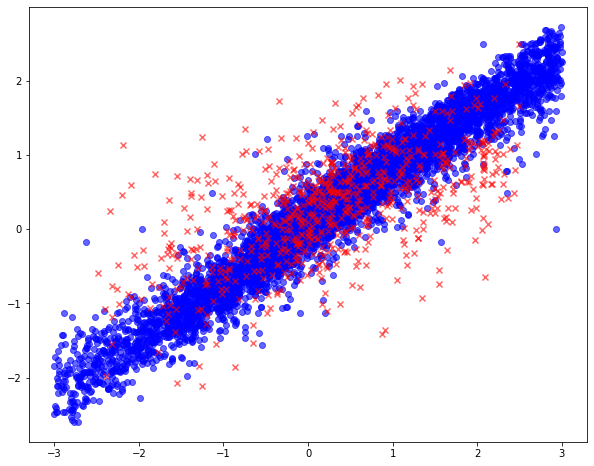

In [25]:
import matplotlib.pyplot as plt

# Combined parity plot for both train and test sets
plt.figure(figsize=(10, 8))

# Plot for test set in red
plt.scatter(y_train, y_pred_train, color='blue', alpha=0.6, label="Train Set", marker='o')
plt.scatter(y_test, y_pred, color='red', alpha=0.6, label="Test Set", marker='x')
# Plot for training set in blue


# 45-degree reference line (perfect prediction line)
min_val = min(y.min(), y_pred.min(), y_train.min(), y_pred_train.min())
max_val = max(y.max(), y_pred.max(), y_train.max(), y_pred_train.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, label="Parity Line")

# Labels, title, and legend
plt.xlabel("Actual $e_f$", fontsize=14)
plt.ylabel("Predicted $e_f$", fontsize=14)
plt.legend(loc='lower right')
plt.grid(True)

# Improve the range for better plot visibility
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

plt.show()


Best hyperparameters: {'n_estimators': 483, 'max_depth': 56, 'min_samples_leaf': 2}


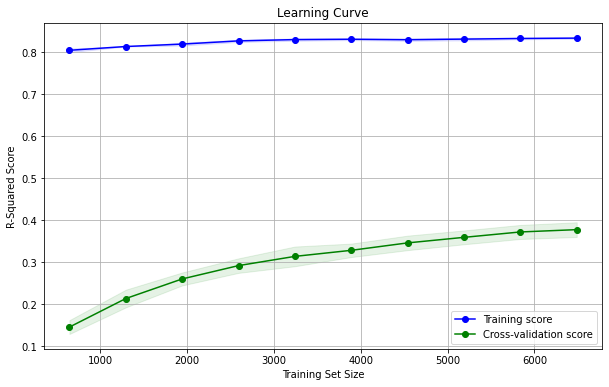

In [80]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, r2_score
import optuna

# Assuming the data preparation code is already executed
# Get the best hyperparameters from the Optuna study
best_params = study.best_params
print("Best hyperparameters:", best_params)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Plot the Learning Curve using the Optimized Hyperparameters
def plot_learning_curve(X, y, params, title="Learning Curve"):
    # Initialize the model with the best parameters
    model = RandomForestRegressor(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        min_samples_leaf=params['min_samples_leaf'],
        random_state=42,
        n_jobs=-1
    )

    # Define training set sizes for the learning curve
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring=make_scorer(r2_score),
        train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1, random_state=42
    )

    # Calculate the mean and standard deviation of train and test scores
    train_scores_mean = train_scores.mean(axis=1)
    train_scores_std = train_scores.std(axis=1)
    test_scores_mean = test_scores.mean(axis=1)
    test_scores_std = test_scores.std(axis=1)

    # Plotting the learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score", color="blue")
    plt.plot(train_sizes, test_scores_mean, 'o-', label="Cross-validation score", color="green")

    # Adding standard deviation shading
    plt.fill_between(train_sizes,
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="blue")
    plt.fill_between(train_sizes,
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="green")

    # Adding plot labels
    plt.title(title)
    plt.xlabel("Training Set Size")
    plt.ylabel("R-Squared Score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# Plot the learning curve using the optimized hyperparameters
plot_learning_curve(X_train_scaled, y_train, best_params)
